# Learning Structured Tabular Distributions with a Lightweight VAE:
# An End‑to‑End PyTorch Walkthrough for Domain‑Specific Tabular Data Synthesis
#
# ✔ Teaching‑friendly  ✔ Low compute (≤10 epochs)  ✔ End‑to‑end  ✔ Visuals  ✔ Fallback synthetic data
#
# Disclaimer: Generated data is synthetic and for research/education only. Do not use to replace real data
# without appropriate validation, risk assessment, and domain approval.


# Structured Evaluation of Synthetic Tabular Data
# https://arxiv.org/abs/2403.10424

In [3]:
# =============================
# 1) Setup, Imports, Seeds
# =============================
import os, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [4]:
# Lightweight deps (auto-install if missing)
try:
    from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
    from sklearn.decomposition import PCA
    from sklearn.model_selection import train_test_split
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn", "pandas", "numpy"])
    from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
    from sklearn.decomposition import PCA
    from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("artifacts", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)


In [5]:
# Config (edit here)
CFG = {
    "epochs": 10,
    "batch_size": 256,
    "lr": 2e-3,
    "latent_dim": 16,
    "hidden": 128,
    "test_size": 0.2,
    "max_rows": 20000,      # cap rows for low compute
    "dataset": "adult",     # preferred; fallback to synthetic if not available
}

print("Device:", DEVICE)


Device: cuda


In [7]:
# ==============================================
# 2) Data Module: Load or Fallback to Synthetic
# ==============================================

def load_adult_or_fallback(max_rows: int = 20000):
    """Try to load the UCI Adult income dataset via OpenML. Fallback to a synthetic
    mixed‑type dataset if unavailable (e.g., offline environments). Returns (df, num_cols, cat_cols)."""
    try:
        from sklearn.datasets import fetch_openml
        adult = fetch_openml(name="adult", version=2, as_frame=True)
        df = adult.frame.copy()
        # Clean: drop rows with missing values symbol '?' if present
        df.replace('?', np.nan, inplace=True)
        df.dropna(inplace=True)
        # Cap rows
        if len(df) > max_rows:
            df = df.sample(max_rows, random_state=SEED)
        # Identify numeric/categorical
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        cat_cols = [c for c in df.columns if c not in num_cols]
        # Optional: keep target as categorical too
        return df.reset_index(drop=True), num_cols, cat_cols
    except Exception as e:
        print("Fallback to synthetic dataset (reason:", str(e)[:120], ")")
        return make_synthetic_tabular(max_rows)

def make_synthetic_tabular(n: int = 10000):
    """Create a synthetic, adult‑like tabular dataset with 4 numeric and 4 categorical features
    + a categorical target. This is small but sufficient for teaching the pipeline.
    Returns (df, num_cols, cat_cols)."""
    rng = np.random.default_rng(SEED)
    # Numeric features: age, hours, capital_gain, capital_loss (bounded)
    age = rng.normal(40, 12, n).clip(18, 90)
    hours = rng.normal(40, 8, n).clip(1, 80)
    cap_gain = rng.exponential(300, n)
    cap_loss = rng.exponential(60, n)

    # Categorical features
    workclass = rng.choice(["Private", "Self-emp", "Gov", "Unemployed"], n, p=[0.7, 0.1, 0.18, 0.02])
    education = rng.choice(["HS", "Bachelors", "Masters", "PhD"], n, p=[0.5, 0.3, 0.17, 0.03])
    marital = rng.choice(["Never-married", "Married", "Divorced"], n, p=[0.35, 0.55, 0.10])
    sex = rng.choice(["Male", "Female"], n, p=[0.53, 0.47])

    # Target (income) depends on some variables (introduce correlation)
    prob_high = (
        0.2
        + 0.003 * (age - 30)
        + 0.005 * (hours - 35)
        + 0.001 * np.log1p(cap_gain)
        - 0.0008 * np.log1p(cap_loss)
        + (education == "Bachelors") * 0.08
        + (education == "Masters") * 0.16
        + (education == "PhD") * 0.22
        + (workclass == "Gov") * 0.03
        + (workclass == "Self-emp") * 0.02
    )
    prob_high = np.clip(prob_high, 0.01, 0.95)
    income = (rng.random(n) < prob_high).astype(int)
    income = np.where(income==1, ">50K", "<=50K")

    df = pd.DataFrame({
        "age": age.round(0),
        "hours": hours.round(1),
        "capital_gain": cap_gain.round(0),
        "capital_loss": cap_loss.round(0),
        "workclass": workclass,
        "education": education,
        "marital": marital,
        "sex": sex,
        "income": income,
    })
    num_cols = ["age", "hours", "capital_gain", "capital_loss"]
    cat_cols = ["workclass", "education", "marital", "sex", "income"]
    return df, num_cols, cat_cols

# Load dataset
raw_df, NUM_COLS, CAT_COLS = load_adult_or_fallback(CFG["max_rows"])
print(f"Loaded data: {raw_df.shape[0]} rows, {len(NUM_COLS)} numeric, {len(CAT_COLS)} categorical")



Loaded data: 20000 rows, 6 numeric, 9 categorical


In [8]:
# ==================================
# 3) Vectorizer: to/from tensors
# ==================================
class TabularVectorizer:
    def __init__(self, num_cols: List[str], cat_cols: List[str]):
        self.num_cols = list(num_cols)
        self.cat_cols = list(cat_cols)
        self.num_scaler = MinMaxScaler()
        self.cat_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.cat_sizes: List[int] = []  # lengths of each one-hot block
        self.total_num_dim = 0
        self.total_cat_dim = 0

    def fit(self, df: pd.DataFrame):
        X_num = df[self.num_cols].astype(float).values if self.num_cols else np.empty((len(df),0))
        X_cat = df[self.cat_cols].astype(str).values if self.cat_cols else np.empty((len(df),0))
        if X_num.size:
            self.num_scaler.fit(X_num)
            self.total_num_dim = X_num.shape[1]
        if X_cat.size:
            OH = self.cat_enc.fit_transform(X_cat)
            self.cat_sizes = [len(c) for c in self.cat_enc.categories_]
            self.total_cat_dim = OH.shape[1]
        return self

    def transform(self, df: pd.DataFrame) -> np.ndarray:
        X_num = df[self.num_cols].astype(float).values if self.num_cols else np.empty((len(df),0))
        X_cat = df[self.cat_cols].astype(str).values if self.cat_cols else np.empty((len(df),0))
        X_num_scaled = self.num_scaler.transform(X_num) if X_num.size else np.empty((len(df),0))
        X_cat_oh = self.cat_enc.transform(X_cat) if X_cat.size else np.empty((len(df),0))
        return np.hstack([X_num_scaled, X_cat_oh]).astype(np.float32)

    def inverse_transform(self, arr: np.ndarray) -> pd.DataFrame:
        n = arr.shape[0]
        out = {}
        start = 0
        if self.total_num_dim:
            num = arr[:, start:start+self.total_num_dim]
            num_inv = self.num_scaler.inverse_transform(np.clip(num, 0, 1))
            for i, col in enumerate(self.num_cols):
                out[col] = num_inv[:, i]
            start += self.total_num_dim
        if self.total_cat_dim:
            cat_block = arr[:, start:start+self.total_cat_dim]
            # Split into groups and argmax
            idx = 0
            for col, size, cats in zip(self.cat_cols, self.cat_sizes, self.cat_enc.categories_):
                logits = cat_block[:, idx:idx+size]
                choice = logits.argmax(axis=1)
                out[col] = np.array([cats[j] for j in choice])
                idx += size
        return pd.DataFrame(out)

    def cat_slices(self) -> List[Tuple[int,int]]:
        """Return start,end indices for each categorical group in the concatenated array."""
        slices = []
        start = self.total_num_dim
        for sz in self.cat_sizes:
            slices.append((start, start+sz))
            start += sz
        return slices

VEC = TabularVectorizer(NUM_COLS, CAT_COLS).fit(raw_df)
X_all = VEC.transform(raw_df)
X_train, X_val = train_test_split(X_all, test_size=CFG["test_size"], random_state=SEED, shuffle=True)
print("Vectorized dims — numeric:", VEC.total_num_dim, "categorical total:", VEC.total_cat_dim, "total:", X_all.shape[1])


Vectorized dims — numeric: 6 categorical total: 99 total: 105


In [9]:
# ==============================
# 4) PyTorch Dataset & Loader
# ==============================
class TabDataset(Dataset):
    def __init__(self, X: np.ndarray, cat_slices: List[Tuple[int,int]]):
        self.X = torch.from_numpy(X)
        self.cat_slices = cat_slices
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx]
        return x

train_ds = TabDataset(X_train, VEC.cat_slices())
val_ds   = TabDataset(X_val,   VEC.cat_slices())
train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG["batch_size"], shuffle=False)

INPUT_DIM = X_all.shape[1]
NUM_DIM = VEC.total_num_dim
CAT_SLICES = VEC.cat_slices()  # list of (start,end)


In [10]:
# ==================
# 5) VAE Model
# ==================
class TabVAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int = 16, hidden: int = 128, num_dim: int = 0, cat_slices: List[Tuple[int,int]] = []):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_dim = num_dim
        self.cat_slices = cat_slices

        # Encoder
        self.enc = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
        )
        self.mu = nn.Linear(hidden, latent_dim)
        self.logvar = nn.Linear(hidden, latent_dim)

        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, input_dim)  # outputs: num in [0,1] (we'll sigmoid), cat logits as-is
        )

    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

# Loss functions: numeric -> MSE on sigmoid(out), categorical -> CE per group
class VAELoss:
    def __init__(self, num_dim: int, cat_slices: List[Tuple[int,int]], beta_kl: float = 1.0):
        self.num_dim = num_dim
        self.cat_slices = cat_slices
        self.beta_kl = beta_kl
        self.mse = nn.MSELoss(reduction='mean')
        self.ce = nn.CrossEntropyLoss(reduction='mean')

    def __call__(self, out, x, mu, logvar):
        # Numeric reconstruction
        recon_num = torch.sigmoid(out[:, :self.num_dim]) if self.num_dim>0 else None
        target_num = x[:, :self.num_dim] if self.num_dim>0 else None
        mse_loss = self.mse(recon_num, target_num) if self.num_dim>0 else torch.tensor(0.0, device=x.device)

        # Categorical reconstruction (sum CE over groups)
        ce_loss = torch.tensor(0.0, device=x.device)
        for (s, e) in self.cat_slices:
            logits = out[:, s:e]
            target_oh = x[:, s:e]
            target_idx = target_oh.argmax(dim=1)
            ce_loss = ce_loss + self.ce(logits, target_idx)

        # KL divergence
        kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        loss = mse_loss + ce_loss + self.beta_kl * kld
        return loss, mse_loss, ce_loss, kld

model = TabVAE(INPUT_DIM, CFG["latent_dim"], CFG["hidden"], NUM_DIM, CAT_SLICES).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=CFG["lr"])
crit = VAELoss(NUM_DIM, CAT_SLICES, beta_kl=1.0)

In [11]:
# ============================
# 6) Train / Validate Loops
# ============================
train_hist = {"loss":[], "mse":[], "ce":[], "kld":[]}
val_hist   = {"loss":[], "mse":[], "ce":[], "kld":[]}

for epoch in range(1, CFG["epochs"]+1):
    model.train()
    sums = np.zeros(4, dtype=np.float64)
    n_batches = 0
    for xb in tqdm(train_loader, desc=f"Epoch {epoch}/{CFG['epochs']} [train]"):
        xb = xb.to(DEVICE)
        out, mu, logvar = model(xb)
        loss, mse, ce, kld = crit(out, xb, mu, logvar)
        opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 5.0); opt.step()
        sums += np.array([loss.item(), mse.item(), ce.item(), kld.item()]); n_batches += 1
    train_hist["loss"].append(sums[0]/n_batches); train_hist["mse"].append(sums[1]/n_batches)
    train_hist["ce"].append(sums[2]/n_batches);  train_hist["kld"].append(sums[3]/n_batches)

    # validation
    model.eval()
    sums = np.zeros(4, dtype=np.float64)
    n_batches = 0
    with torch.no_grad():
        for xb in tqdm(val_loader, desc=f"Epoch {epoch}/{CFG['epochs']} [val]"):
            xb = xb.to(DEVICE)
            out, mu, logvar = model(xb)
            loss, mse, ce, kld = crit(out, xb, mu, logvar)
            sums += np.array([loss.item(), mse.item(), ce.item(), kld.item()]); n_batches += 1
    val_hist["loss"].append(sums[0]/n_batches); val_hist["mse"].append(sums[1]/n_batches)
    val_hist["ce"].append(sums[2]/n_batches);  val_hist["kld"].append(sums[3]/n_batches)

    # checkpoint
    torch.save(model.state_dict(), os.path.join("checkpoints", f"tabvae_epoch{epoch}.pth"))

Epoch 10/10 [val]: 100%|██████████| 16/16 [00:00<00:00, 319.04it/s]


In [12]:
# ======================
# 7) Sampling & Inverse
# ======================
@torch.no_grad()
def sample_synthetic(n: int = 2000) -> pd.DataFrame:
    model.eval()
    z = torch.randn(n, CFG["latent_dim"], device=DEVICE)
    out = model.decode(z)
    out = out.cpu().numpy()
    # For numeric we pass sigmoid; for categorical logits as-is
    if NUM_DIM>0:
        out[:, :NUM_DIM] = 1/(1+np.exp(-out[:, :NUM_DIM]))
    df_syn = VEC.inverse_transform(out)
    return df_syn

synthetic_df = sample_synthetic(2000)
synthetic_path = os.path.join("artifacts", "synthetic_samples.csv")
synthetic_df.to_csv(synthetic_path, index=False)
print(f"Saved synthetic samples to {synthetic_path} (rows={len(synthetic_df)})")


Saved synthetic samples to artifacts/synthetic_samples.csv (rows=2000)


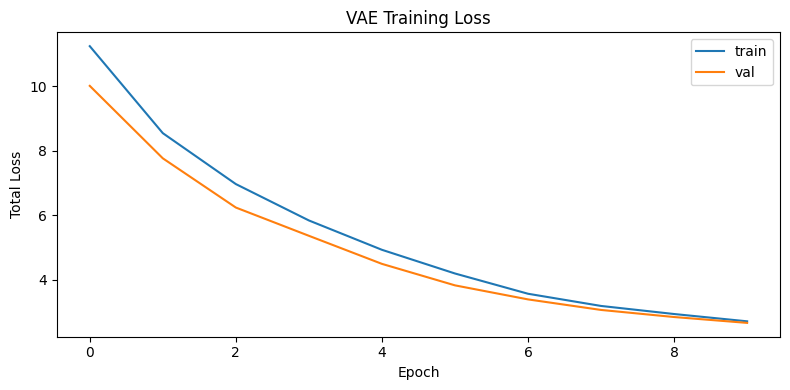

In [19]:
# =====================
# 8) Visualizations
# =====================
# 8.1 Loss curves
plt.figure(figsize=(8,4))
plt.plot(train_hist["loss"], label="train")
plt.plot(val_hist["loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("Total Loss"); plt.title("VAE Training Loss"); plt.legend(); plt.tight_layout(); plt.show()

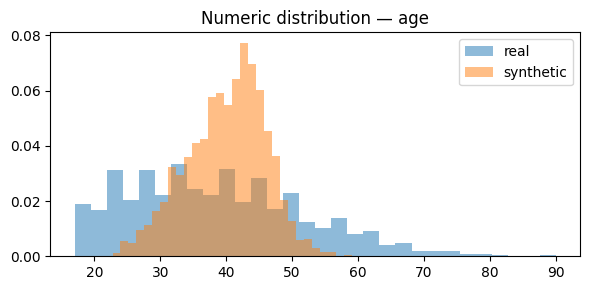

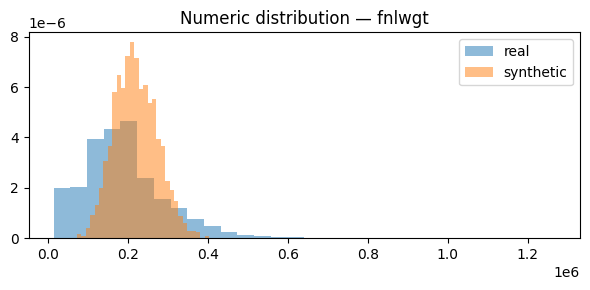

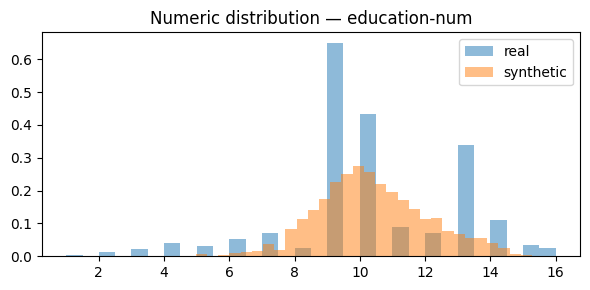

In [20]:
# 8.2 Numeric distributions: overlay hist for up to 3 numeric cols
num_to_show = NUM_COLS[:3]
for col in num_to_show:
    plt.figure(figsize=(6,3))
    plt.hist(raw_df[col].values, bins=30, alpha=0.5, density=True, label="real")
    plt.hist(synthetic_df[col].values, bins=30, alpha=0.5, density=True, label="synthetic")
    plt.title(f"Numeric distribution — {col}"); plt.legend(); plt.tight_layout(); plt.show()

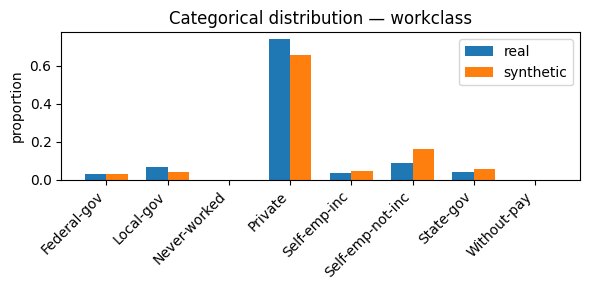

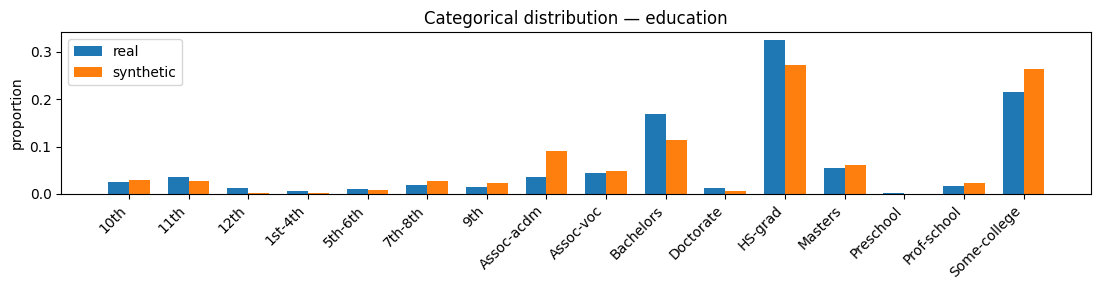

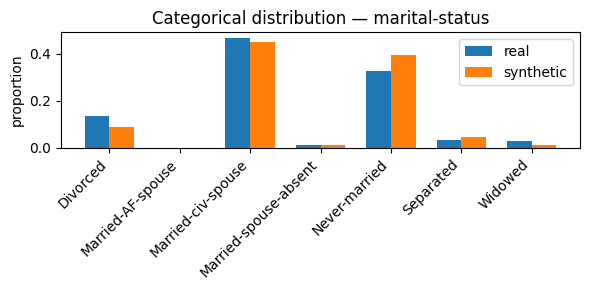

In [21]:
# 8.3 Categorical distributions: bar plots for up to 3 categorical cols
cat_to_show = CAT_COLS[:3]
for col in cat_to_show:
    real_counts = raw_df[col].value_counts(normalize=True)
    syn_counts = synthetic_df[col].value_counts(normalize=True)
    cats = sorted(set(real_counts.index).union(set(syn_counts.index)))
    r = [real_counts.get(c,0) for c in cats]
    s = [syn_counts.get(c,0) for c in cats]
    x = np.arange(len(cats))
    width = 0.35
    plt.figure(figsize=(max(6, len(cats)*0.7),3))
    plt.bar(x - width/2, r, width, label='real')
    plt.bar(x + width/2, s, width, label='synthetic')
    plt.xticks(x, cats, rotation=45, ha='right')
    plt.ylabel('proportion'); plt.title(f"Categorical distribution — {col}"); plt.legend(); plt.tight_layout(); plt.show()


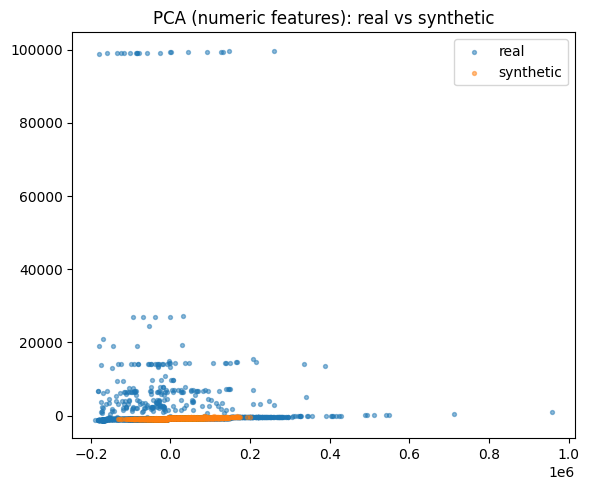

In [22]:
# 8.4 PCA scatter: real vs synthetic (on numeric only if available, else on full vector space)
if len(NUM_COLS) >= 2:
    pca = PCA(n_components=2, random_state=SEED)
    n_real = min(3000, len(raw_df))
    n_syn  = min(3000, len(synthetic_df))
    R = raw_df.sample(n_real, random_state=SEED).reset_index(drop=True)
    S = synthetic_df.sample(n_syn, random_state=SEED).reset_index(drop=True)
    # use numeric subset for PCA to avoid huge one-hot
    Z = np.vstack([R[NUM_COLS].values, S[NUM_COLS].values])
    Z2 = pca.fit_transform(Z)
    plt.figure(figsize=(6,5))
    plt.scatter(Z2[:n_real,0], Z2[:n_real,1], s=8, alpha=0.5, label='real')
    plt.scatter(Z2[n_real:,0], Z2[n_real:,1], s=8, alpha=0.5, label='synthetic')
    plt.title('PCA (numeric features): real vs synthetic'); plt.legend(); plt.tight_layout(); plt.show()


/tmp/ipython-input-3517453309.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


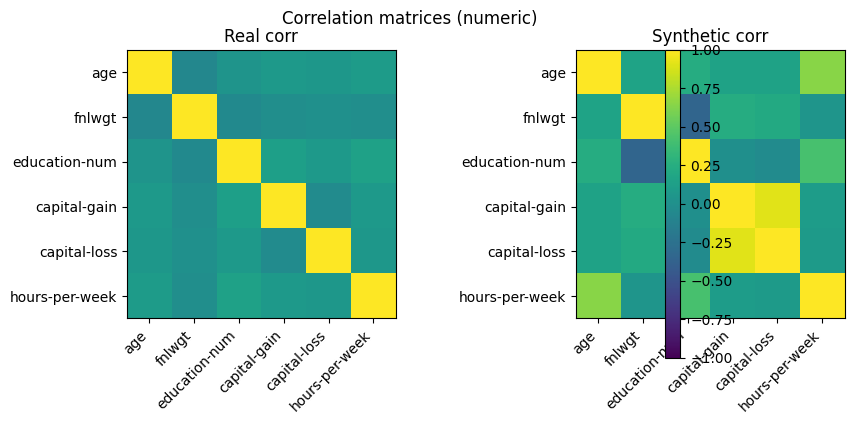

In [23]:
# 8.5 Correlation heatmap comparison (numeric only)
if len(NUM_COLS) >= 2:
    def corr_mat(df):
        return np.corrcoef(df[NUM_COLS].astype(float).values.T)
    C_real = corr_mat(raw_df)
    C_syn = corr_mat(synthetic_df)
    fig, axes = plt.subplots(1,2, figsize=(9,4))
    im0 = axes[0].imshow(C_real, vmin=-1, vmax=1)
    axes[0].set_title('Real corr'); axes[0].set_xticks(range(len(NUM_COLS))); axes[0].set_xticklabels(NUM_COLS, rotation=45, ha='right'); axes[0].set_yticks(range(len(NUM_COLS))); axes[0].set_yticklabels(NUM_COLS)
    im1 = axes[1].imshow(C_syn, vmin=-1, vmax=1)
    axes[1].set_title('Synthetic corr'); axes[1].set_xticks(range(len(NUM_COLS))); axes[1].set_xticklabels(NUM_COLS, rotation=45, ha='right'); axes[1].set_yticks(range(len(NUM_COLS))); axes[1].set_yticklabels(NUM_COLS)
    fig.colorbar(im1, ax=axes.ravel().tolist())
    plt.suptitle('Correlation matrices (numeric)')
    plt.tight_layout(); plt.show()


In [15]:
# ==========================
# 9) Results & README dump
# ==========================
report = f"""
# Tabular Data Synthesis with a Lightweight VAE (PyTorch)

- Dataset: {CFG['dataset']} (fallback synthetic if offline)
- Rows: real={len(raw_df)}, synthetic={len(synthetic_df)}
- Vectorized dims: numeric={NUM_DIM}, categorical_total={VEC.total_cat_dim}, total={INPUT_DIM}
- Training: epochs={CFG['epochs']}, batch_size={CFG['batch_size']}, lr={CFG['lr']}, latent_dim={CFG['latent_dim']}

## Notes
- Numeric features optimized with MSE on sigmoid outputs in [0,1] (MinMax scaled).
- Categorical features optimized with cross-entropy across one-hot groups (greedy argmax at sampling).
- Visuals included: loss curves, hist overlays (numeric), bar charts (categorical), PCA scatter, correlation matrices.

## Limitations & Next Steps
- VAE may underfit complex categorical dependencies; consider Conditional VAE or Gaussian Copula + CTGAN/TVAE for improved fidelity.
- Add privacy checks (distance to nearest real record, membership inference tests) if using in sensitive settings.
- For imbalanced categories, consider class‑aware sampling or focal losses on categorical heads.
"""

In [17]:
print(report)


# Tabular Data Synthesis with a Lightweight VAE (PyTorch)

- Dataset: adult (fallback synthetic if offline)
- Rows: real=20000, synthetic=2000
- Vectorized dims: numeric=6, categorical_total=99, total=105
- Training: epochs=10, batch_size=256, lr=0.002, latent_dim=16

## Notes
- Numeric features optimized with MSE on sigmoid outputs in [0,1] (MinMax scaled).
- Categorical features optimized with cross-entropy across one-hot groups (greedy argmax at sampling).
- Visuals included: loss curves, hist overlays (numeric), bar charts (categorical), PCA scatter, correlation matrices.

## Limitations & Next Steps
- VAE may underfit complex categorical dependencies; consider Conditional VAE or Gaussian Copula + CTGAN/TVAE for improved fidelity.
- Add privacy checks (distance to nearest real record, membership inference tests) if using in sensitive settings.
- For imbalanced categories, consider class‑aware sampling or focal losses on categorical heads.



In [18]:
with open(os.path.join("artifacts", "README_PROJECT.md"), "w") as f:
    f.write(report)

print("\nDone. Synthetic CSV, checkpoints, and README saved under ./artifacts and ./checkpoints.")


Done. Synthetic CSV, checkpoints, and README saved under ./artifacts and ./checkpoints.
